# Koopman kernel models for TC Tracks (Data and standardization)

Here we have a closer look at the dataset, the interesting features of the tropical cyclone data and data standardization.
[Work in progress]

In [1]:
# %matplotlib inline
from climada.hazard import TCTracks
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.plot_utils import plot_feature, plot_features
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Get data and preprocess

BASIN_ENV_PRESSURE = {
    '': DEF_ENV_PRESSURE,
    'EP': 1010, 'NA': 1010, 'SA': 1010,
    'NI': 1005, 'SI': 1005, 'WP': 1005,
    'SP': 1004,
}

In [2]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-09-28 12:42:03,756 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


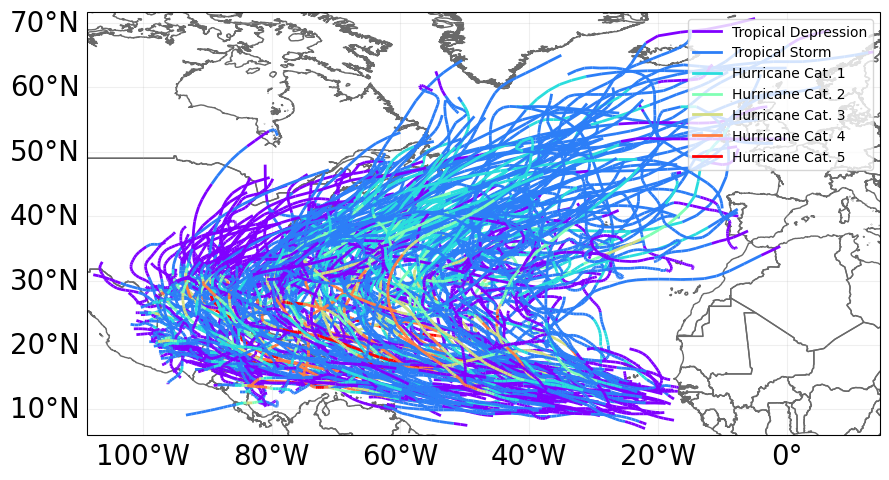

In [3]:
ax = tc_tracks.plot()

### Checking data quality

We plot variables along a few random tracks to get a better picture of how good the data is, i.e. if every feature/variable looks reasonable and that there are no large missing chunks of data.

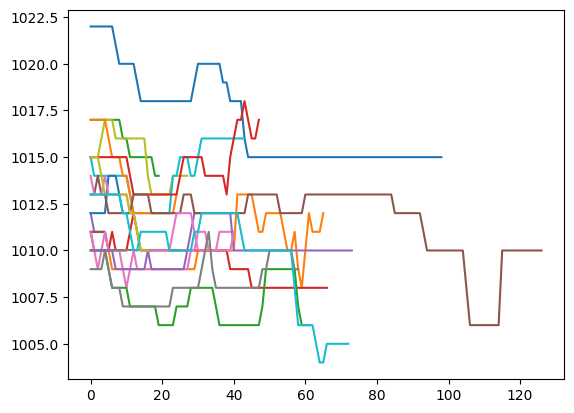

In [4]:
fig, ax = plt.subplots()
plot_feature(tc_tracks, "environmental_pressure", ax, n_tracks=20)

Data cleaning: In some cases some variables, e.g. the radius_max_wind, is constant for almost the full time track. These tracks might be affected by measurement errors or unavailable data. To remove these "corrupted" tracks could enhance model performance. For now, however, we leave all the tracks in the dataset.

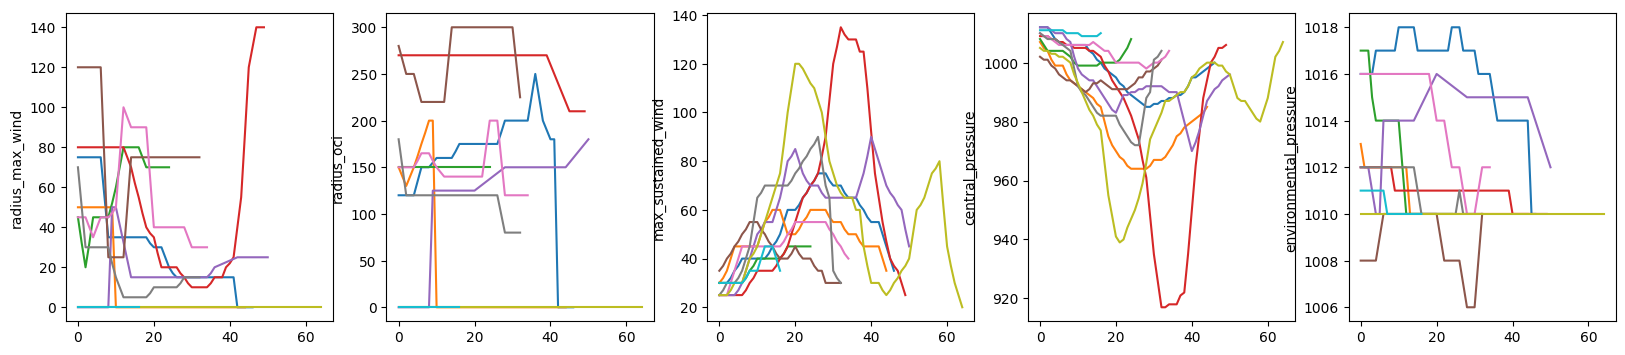

In [5]:
fig, ax = plt.subplots(1,5)
fig.set_size_inches(20,4)
features = [
    "radius_max_wind",
    "radius_oci",
    "max_sustained_wind",
    "central_pressure",
    "environmental_pressure",
]
plot_features(tc_tracks, features, ax, n_tracks=10)

### Data standardisation

An important pre-processing step is data standardisation. This step rescales the data to zero mean and unit variance, a regime where most of the common machine learning tools are targeted at. Also, data standardisation allows for better comparability between prediction performance on different datasets.

As an example, we generate random data and use the sklearn StandardScaler to rescale it to zero mean and unit variance.

In [6]:
data = np.stack(
    [np.random.uniform(0,12,size=100), np.random.uniform(-12,3,size=100), np.random.uniform(2,6,size=100)],
    axis = 1
)

scaler = StandardScaler()
_ = scaler.fit(data)
data_trafo = scaler.transform(data)

print(np.mean(data_trafo[:,0]), np.mean(data_trafo[:,1]), np.mean(data_trafo[:,2]), np.var(data_trafo[:,0]), np.var(data_trafo[:,1]), np.var(data_trafo[:,2]))

-1.5987211554602254e-16 -6.661338147750939e-18 -4.485301019485632e-16 0.9999999999999997 1.0000000000000004 1.0000000000000002


We obtain globally rescaled data with zero mean and unit variance.

We also implement a custom linear scaler that rescales the data set such that it is contained in a given $n$-dimensional interval. Our linear scaler is a bit more general than the `MinMaxScaler` of `sklearn`, since it allows us to scale the dimensions to different intervals.

In [7]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 42
feature_list = ["lat", "lon"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [8]:
# scaler = StandardScaler()
scaler = LinearScaler()
# scaler = MinMaxScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

print(tensor_context_train_transformed.data.reshape(-1,2).mean(axis=0), tensor_context_train_transformed.data.reshape(-1,2).var(axis=0))

Train contexts have shape (8262, 42, 2): 8262 contexts of length 42 with 2 features each
Test contexts have shape (837, 42, 2): 837 contexts of length 42 with 2 features each
[-0.36509848 -0.20820658] [0.08280949 0.09588688]


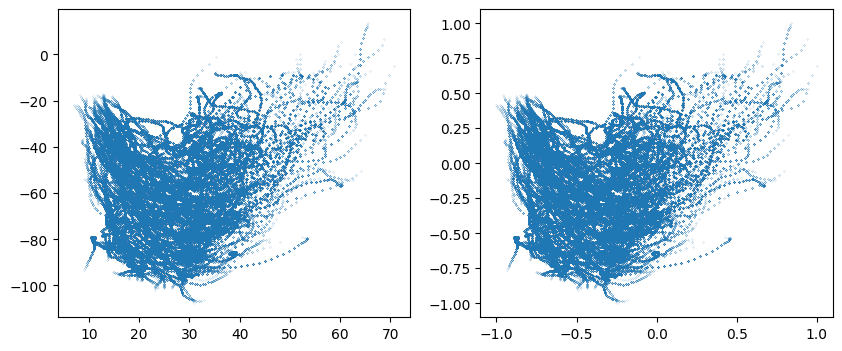

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(tensor_context_train.data.reshape(-1,2)[:,0], tensor_context_train.data.reshape(-1,2)[:,1], marker=".", linestyle='None', markersize=0.2)
ax[1].plot(tensor_context_train_transformed.data.reshape(-1,2)[:,0], tensor_context_train_transformed.data.reshape(-1,2)[:,1], marker=".", linestyle='None', markersize=0.2)

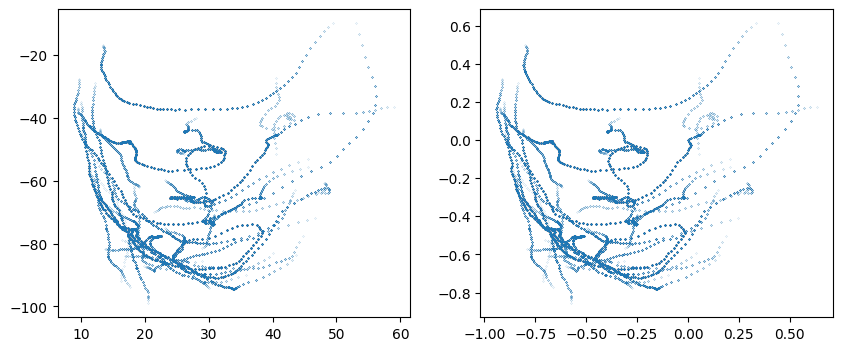

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(tensor_context_test.data.reshape(-1,2)[:,0], tensor_context_test.data.reshape(-1,2)[:,1], marker=".", linestyle='None', markersize=0.2)
ax[1].plot(tensor_context_test_transformed.data.reshape(-1,2)[:,0], tensor_context_test_transformed.data.reshape(-1,2)[:,1], marker=".", linestyle='None', markersize=0.2)

Looks good.